# 1. Environment Setup and Warning Suppression

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# 2. Importing Libraries (TensorFlow, Keras, Matplotlib)

In [4]:
import zipfile
from keras.models import Sequential , Model
from keras.layers import Dense , Dropout , Flatten
from keras.applications import VGG16
from keras.optimizers import Adam
from keras.preprocessing import image
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [5]:
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [6]:
batch_size = 32
epochs = 5
image_row , image_col = 224 , 224
input_shape = (image_row , image_col , 3)

In [7]:
import tarfile
import urllib.request
import os
import shutil

# Downloading the Aircraft Damage Dataset

In [8]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/ZjXM4RKxlBK9__ZjHBLl5A/aircraft-damage-dataset-v1.tar"

tar_filename = "aircraft_damage_dataset_v1.tar"
extracted_folder = "aircraft_damage_dataset_v1"

In [9]:
urllib.request.urlretrieve(url , tar_filename)
print(f'{tar_filename} downloaded successfully')

aircraft_damage_dataset_v1.tar downloaded successfully


In [10]:
if os.path.exists(extracted_folder):
    print(f'{extracted_folder} already exists')

    shutil.rmtree(extracted_folder)
    print(f'{extracted_folder} removed successfully')

In [11]:
with tarfile.open(tar_filename , 'r') as tar:
    tar.extractall()
    print(f'{tar_filename} extracted successfully')

aircraft_damage_dataset_v1.tar extracted successfully


#  Defining Directory Paths

```python
aircraft_damage_dataset_v1/
├── train/
│   ├── dent/
│   └── crack/
├── valid/
│   ├── dent/
│   └── crack/
└── test/
    ├── dent/
    └── crack/

```



In [12]:
extract_path = "aircraft_damage_dataset_v1"
train_dir = os.path.join(extract_path , 'train')
valid_dir = os.path.join(extract_path , 'valid')
test_dir = os.path.join(extract_path,'test')

#  Data Preprocessing and Rescaling

In [13]:
train_datagen = ImageDataGenerator(rescale= 1./255)
valid_datagen = ImageDataGenerator(rescale= 1./255)
test_datagen = ImageDataGenerator(rescale= 1./255)

In [14]:
train_generator =  train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_row, image_col),
    batch_size=batch_size,
    seed = seed_value,
    class_mode='binary',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(image_row, image_col),
    batch_size=batch_size,
    seed = seed_value,
    class_mode='binary',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_row, image_col),
    batch_size = batch_size,
    seed = seed_value,
    class_mode='binary',
    shuffle=True
)

Found 300 images belonging to 2 classes.
Found 96 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


# Loading VGG16 Base Model (Transfer Learning)

In [15]:
base_model = VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = input_shape
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


# Building the Classification Head

In [16]:
output = base_model.layers[-1].output
output = tf.keras.layers.Flatten()(output)
base_model = Model(base_model.input , output)

for layer in base_model.layers:
    layer.trainable = False

In [17]:
model = Sequential()
model.add(base_model)
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

# Compiling the Model

In [18]:
model.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

# Training the Model

In [19]:
history = model.fit(
    train_generator,
    epochs = epochs,
    validation_data = valid_generator,
)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5464 - loss: 0.7536 - val_accuracy: 0.6562 - val_loss: 0.6382
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.6848 - loss: 0.6159 - val_accuracy: 0.6042 - val_loss: 0.6255
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.6644 - loss: 0.6694 - val_accuracy: 0.6354 - val_loss: 0.5977
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.7156 - loss: 0.5339 - val_accuracy: 0.6458 - val_loss: 0.5943
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.7271 - loss: 0.5303 - val_accuracy: 0.7396 - val_loss: 0.5165


# Visualizing Training History (Accuracy & Loss)

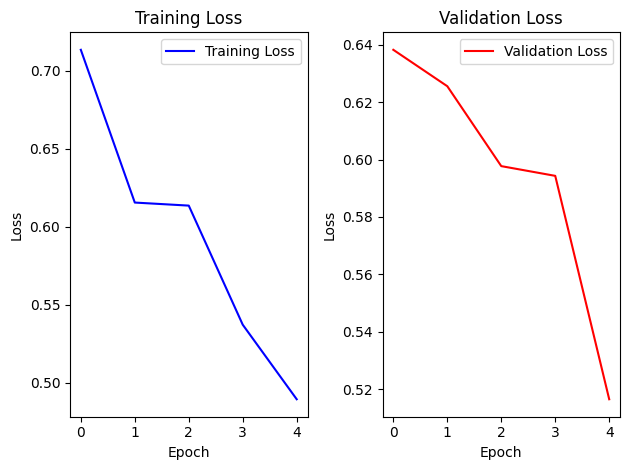

In [20]:
train_history = history.history

plt.subplot(1, 2, 1)
plt.plot(train_history['loss'], label='Training Loss', color='blue')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_history['val_loss'], label='Validation Loss', color='red')
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

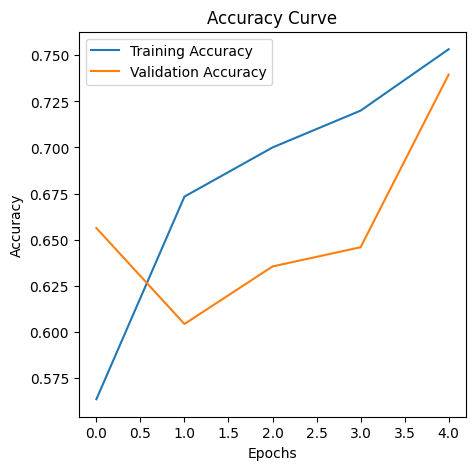

In [21]:
train_history = history.history

plt.figure(figsize=(5, 5))
plt.plot(train_history['accuracy'], label='Training Accuracy')
plt.plot(train_history['val_accuracy'], label='Validation Accuracy')

plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
test_loss , test_accuracy = model.evaluate(test_generator,steps=test_generator.samples // test_generator.batch_size)
print(f'Test Loss: {test_loss:.4f}')
print(f"Test Accuracy: {test_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.7500 - loss: 0.5303
Test Loss: 0.5303
Test Accuracy: 0.7500


In [23]:
import numpy as np
import matplotlib.pyplot as plt

def plot_images_grid(test_images, true_labels, predicted_labels, class_names):
    num_images = len(test_images)
    cols = 3
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(6 * cols, 6 * rows))
    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(test_images[i])
        plt.axis('off')

        true_label_name = class_names[true_labels[i]]
        pred_label_name = class_names[predicted_labels[i]]
        color = 'green' if true_labels[i] == predicted_labels[i] else 'red'
        plt.title(f"T: {true_label_name}\nP: {pred_label_name}", color=color, fontsize=20)

    plt.tight_layout()
    plt.show()

def test_model_on_images(test_generator, model):
    num_samples = int(input("Enter the number of images to display: "))
    all_images = []
    all_true_labels = []

    while len(all_images) < num_samples:
        images, labels = next(test_generator)
        all_images.extend(images)
        all_true_labels.extend(labels)

    test_images = np.array(all_images[:num_samples])
    test_labels = np.array(all_true_labels[:num_samples])

    predictions = model.predict(test_images)
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    class_indices = test_generator.class_indices
    class_names = {v: k for k, v in class_indices.items()}

    plot_images_grid(test_images, test_labels, predicted_classes, class_names)


# Test Samples

Enter the number of images to display: 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


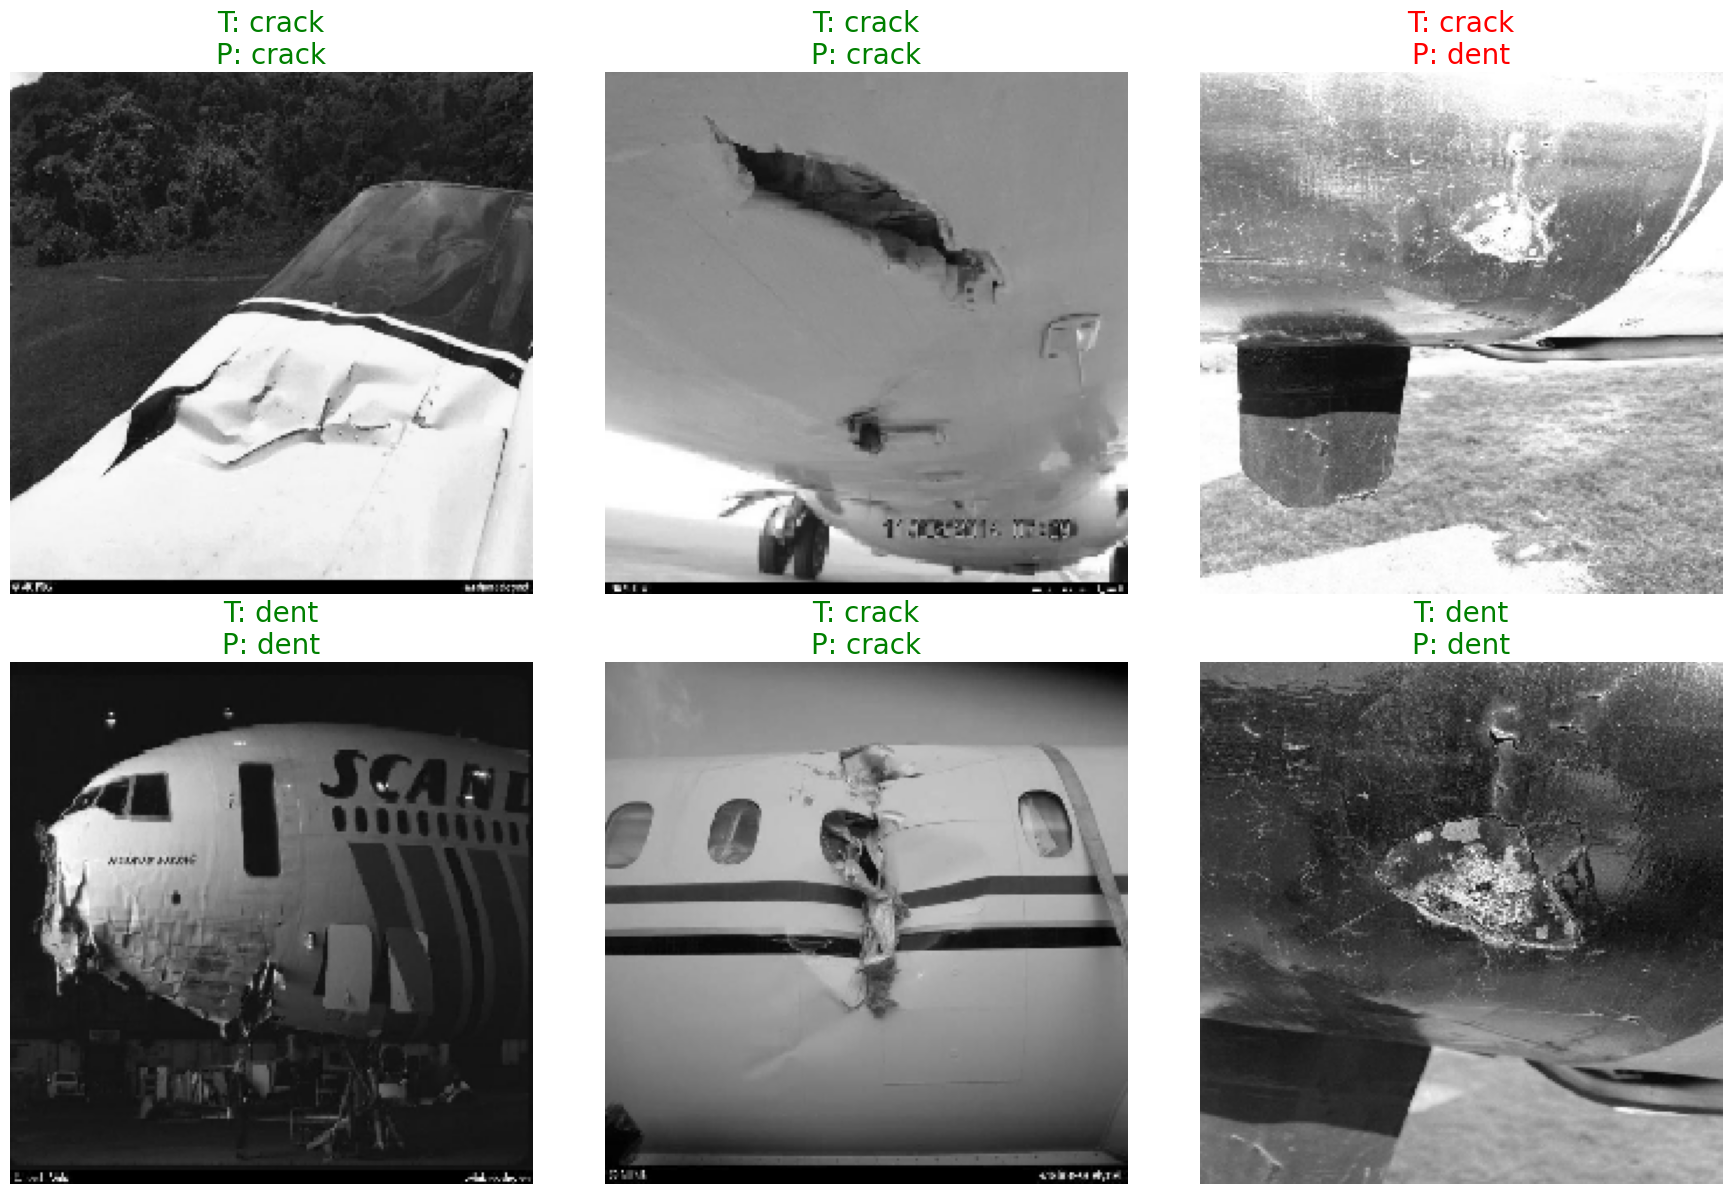

In [24]:
test_model_on_images(test_generator, model)

In [25]:
import torch
from PIL import Image
from transformers import BlipProcessor , BlipForConditionalGeneration

# Visioning Model BlipForConditionalGeneration | Captioning

In [26]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [27]:
class BlipCaptionSummaryLayer(tf.keras.layers.Layer):
    def __init__(self, processor, model, **kwargs):
        """
        Initialize the custom Keras layer with the BLIP processor and model.

        Args:
            processor: The BLIP processor for preparing inputs for the model.
            model: The BLIP model for generating captions or summaries.
        """
        super().__init__(**kwargs)
        self.processor = processor
        self.model = model

    def call(self, image_path, task):
        # Use tf.py_function to run the custom image processing and text generation
        return tf.py_function(self.process_image, [image_path, task], tf.string)

    def process_image(self, image_path, task):
        """
        Perform image loading, preprocessing, and text generation.

        Args:
            image_path: Path to the image file as a string.
            task: The type of task ("caption" or "summary").

        Returns:
            The generated caption or summary as a string.
        """
        try:
            image_path_str = image_path.numpy().decode("utf-8")

            image = Image.open(image_path_str).convert("RGB")

            if task.numpy().decode("utf-8") == "caption":
                prompt = "This is a picture of"  # Modify prompt for more natural output
            else:
                prompt = "This is a detailed photo showing"  # Modify for summary

            inputs = self.processor(images=image, text=prompt, return_tensors="pt")

            output = self.model.generate(**inputs)

            result = self.processor.decode(output[0], skip_special_tokens=True)
            return result
        except Exception as e:
            print(f"Error: {e}")
            return "Error processing image"


In [28]:
def generate_text(image_path, task):
    blip_layer = BlipCaptionSummaryLayer(processor, model)

    return blip_layer(image_path, task)

# Generate Text

In [29]:
image_path = tf.constant("aircraft_damage_dataset_v1/test/dent/144_10_JPG_jpg.rf.4d008cc33e217c1606b76585469d626b.jpg")  # actual path of image

# Generate a caption for the image
caption = generate_text(image_path, tf.constant("caption"))
# Decode and print the generated caption
print("Caption:", caption.numpy().decode("utf-8"))

# Generate a summary for the image
summary = generate_text(image_path, tf.constant("summary"))
# Decode and print the generated summary
print("Summary:", summary.numpy().decode("utf-8"))

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Caption: this is a picture of a plane
Summary: this is a detailed photo showing the engine of a boeing 747


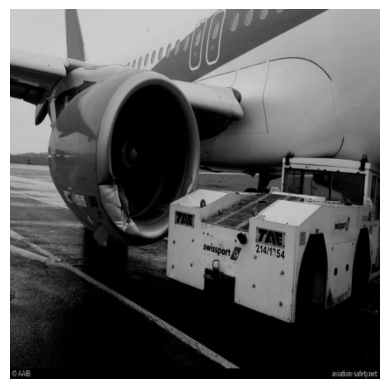

In [30]:
image_url = "aircraft_damage_dataset_v1/test/dent/144_10_JPG_jpg.rf.4d008cc33e217c1606b76585469d626b.jpg"
img = plt.imread(image_url)
plt.imshow(img)
plt.axis('off')
plt.show()

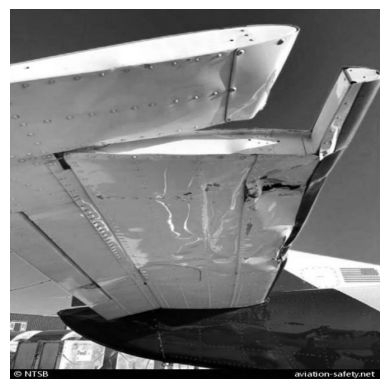

<tf.Tensor: shape=(), dtype=string, numpy=b'this is a picture of the wing of a plane'>

In [31]:
img1 ="/content/aircraft_damage_dataset_v1/test/crack/101_1_JPG_jpg.rf.695bc0b3ba5ada38ee27d71dbacaf408.jpg"
img2 = "/content/aircraft_damage_dataset_v1/test/dent/143_13_JPG_jpg.rf.29ff136584e5e0cc50f837396e6995a2.jpg"
img3 = "/content/aircraft_damage_dataset_v1/test/dent/136_15_JPG_jpg.rf.35554276cb237619af1cf7fb465e3f46.jpg"
img4 = "/content/aircraft_damage_dataset_v1/test/crack/14_23_JPG_jpg.rf.b7dbf66f2939f210dcf0bcbd1d814e8f.jpg"

image_tensor = tf.constant(img3)
task_tensor = tf.constant("caption")
img = plt.imread(img3)
plt.imshow(img)
plt.axis('off')
plt.show()

caption_output = generate_text(image_tensor, task_tensor)

caption_output
